We evaluate the hyperparameters for WalkSAT tested on 100 NAE instances.

In [63]:
import os
import sys
import warnings
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
warnings.filterwarnings('ignore')

In [64]:
import h5py
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
parent_dir = os.path.dirname(os.getcwd())
dir = f"{parent_dir}/experiments/exp4/results"

We extract the date and combine into one dataframe.

In [66]:
def tiebreak(filename):
	return filename.split("_")[1]

def k_val(filename):
	return int(filename.split("_")[2])

def hyperparameters(filename, tb):
	p = float(filename.split("_")[3].replace(".hdf5", ""))
	w1 = None
	w2 = None
	if tb == 'm2' or tb == 'm2b2':
		w1 = round(float(filename.split("_")[4]), 3)
		w2 = round(float(filename.split("_")[5].replace(".hdf5", "")), 3)
	return p, w1, w2

def get_median_mean(filepath):
	with h5py.File(filepath, "r") as f:
		tensor = f["times"][()]
		return np.median(tensor), np.mean(tensor)

# Create an empty Pandas dataframe with the desired columns
columns = ["k", "tiebreak", "p", "w1", "w2", "median", "mean"]
df = pd.DataFrame(columns=columns)

# Loop through all the HDF5 files in the directory and add their data to the dataframe
for filepath in glob.glob(f'{dir}/rt_*.hdf5'):
	filename = filepath.split("/")[-1]
	tb = tiebreak(filename)
	k = k_val(filename)
	p, w1, w2 = hyperparameters(filename, tb)
	if p > 0:
		median, mean = get_median_mean(filepath)
		df = df.append({"k": k, "tiebreak": tb, "p": p, "w1": w1, "w2": w2, "median": median, "mean": mean}, ignore_index=True)


In [67]:
df

,k,tiebreak,p,w1,w2,median,mean
0,10,m2,0.05,0.2,0.8,4.0,9.90
1,4,m2,0.40,0.3,0.7,3.0,3.86
2,10,m2,0.95,0.9,0.1,5.0,6.92
3,7,m2,0.60,0.6,0.4,4.5,5.88
4,10,b,0.35,None,None,5.0,7.24
...,...,...,...,...,...,...,...
3835,6,m2,0.40,0.0,1.0,4.0,4.64
3836,7,m2,0.40,0.0,1.0,4.0,5.53
3837,3,m2b2,0.25,1.0,0.0,3.0,3.59
3838,10,b,0.45,None,None,4.0,5.64


In [68]:
min_median = df.groupby(['tiebreak', 'k'])['median'].transform('min')
lowest_median_combinations = df[df['median'] == min_median]
lowest_median_combinations = lowest_median_combinations[['tiebreak', 'k', 'p', 'w1', 'w2', 'median']]
lowest_median_combinations = lowest_median_combinations.sort_values(['tiebreak', 'k'])
print(lowest_median_combinations)

     tiebreak   k     p    w1    w2  median
236         b   3  0.05  None  None     3.0
640         b   3  0.65  None  None     3.0
657         b   3  0.75  None  None     3.0
759         b   3  0.90  None  None     3.0
969         b   3  0.40  None  None     3.0
...       ...  ..   ...   ...   ...     ...
1079     m2b2   7  0.65   1.0   0.0     3.5
1776     m2b2   7  0.05   0.6   0.4     3.5
799      m2b2   8  0.40   0.4   0.6     3.0
3150     m2b2   9  0.05   0.7   0.3     3.0
876      m2b2  10  0.25   0.3   0.7     3.0

[830 rows x 6 columns]


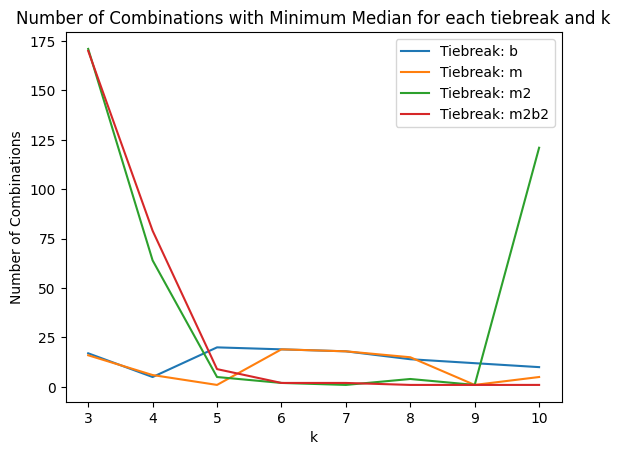

In [69]:
import matplotlib.pyplot as plt

# Count the number of combinations with the minimum median for each tiebreak and k
num_combinations = lowest_median_combinations.groupby(['tiebreak', 'k']).size()

# Iterate over each tiebreak type
for tiebreak in num_combinations.index.get_level_values('tiebreak').unique():
    tiebreak_combinations = num_combinations.loc[tiebreak]
    # Plot the graph for the tiebreak type
    plt.plot(tiebreak_combinations.index, tiebreak_combinations.values, label=f'Tiebreak: {tiebreak}')

# Set the plot labels and title
plt.xlabel('k')
plt.ylabel('Number of Combinations')
plt.title('Number of Combinations with Minimum Median for each tiebreak and k')

plt.legend()
plt.show()


We analyse the dependence on noise.

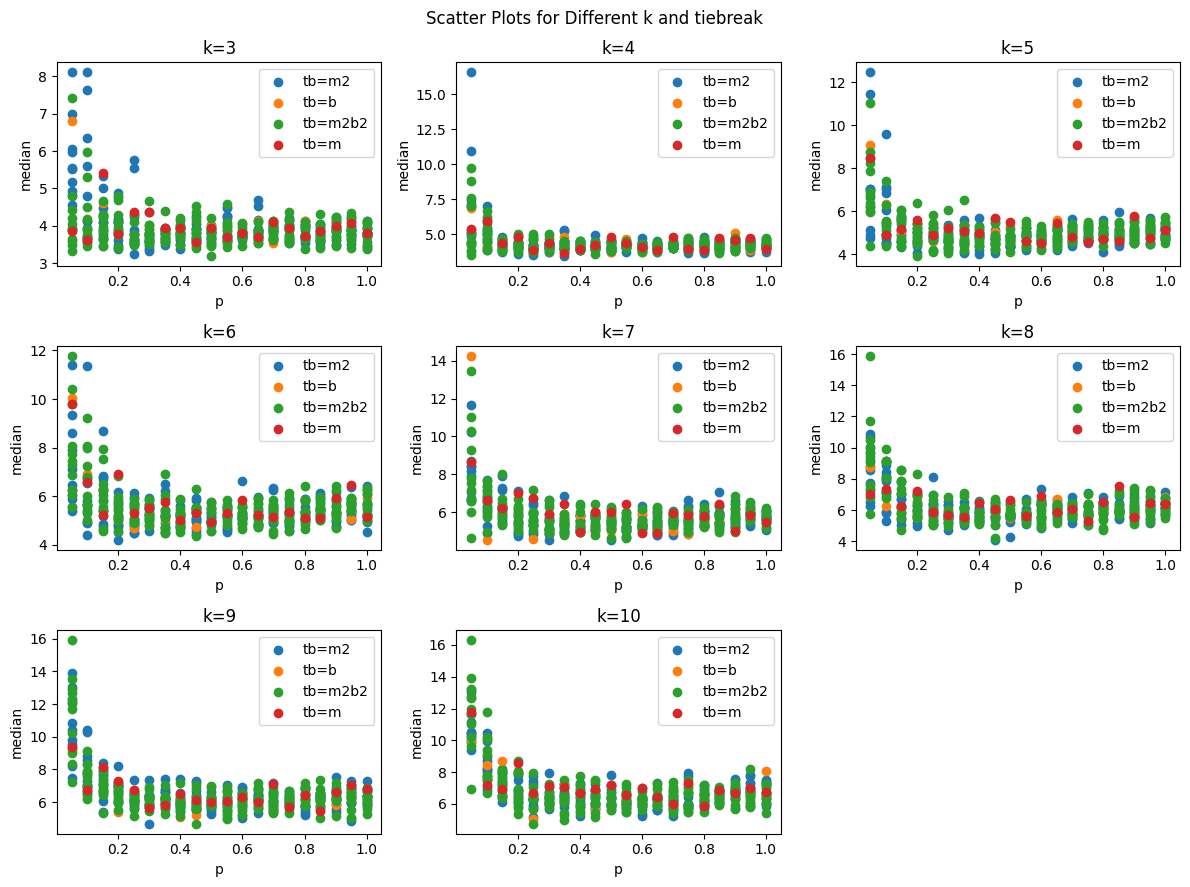

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique tiebreak values
tiebreak_values = df['tiebreak'].unique()

# Group the data by k
grouped = df.groupby('k')

num_plots = len(grouped)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))
fig.suptitle('Scatter Plots for Different k and tiebreak')

# Flatten the axes array to simplify indexing
axes = axes.flatten()

for i, (k, group_k) in enumerate(grouped):
    ax = axes[i]  # Select the current subplot
    ax.set_title(f"k={k}")
    
    for j, tb in enumerate(tiebreak_values):
        group_tb = group_k[group_k['tiebreak'] == tb]
        
        if len(group_tb) > 0:
            p_values = group_tb['p']
            mean_values = group_tb['mean']
            ax.scatter(p_values, mean_values, label=f"tb={tb}")
    
    ax.set_xlabel('p')
    ax.set_ylabel('median')
    ax.legend()

# Hide unused subplots, if any
for i in range(len(grouped), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [72]:
lowest_median_combinations.to_pickle(f'{dir}/../params')

In [83]:
params = pd.read_pickle(f'{dir}/../params')
params

,tiebreak,k,p,w1,w2,median
236,b,3,0.05,None,None,3.0
640,b,3,0.65,None,None,3.0
657,b,3,0.75,None,None,3.0
759,b,3,0.90,None,None,3.0
969,b,3,0.40,None,None,3.0
...,...,...,...,...,...,...
1079,m2b2,7,0.65,1.0,0.0,3.5
1776,m2b2,7,0.05,0.6,0.4,3.5
799,m2b2,8,0.40,0.4,0.6,3.0
3150,m2b2,9,0.05,0.7,0.3,3.0


In [84]:
params = params[params.k == 3] 
params

,tiebreak,k,p,w1,w2,median
236,b,3,0.05,None,None,3.0
640,b,3,0.65,None,None,3.0
657,b,3,0.75,None,None,3.0
759,b,3,0.90,None,None,3.0
969,b,3,0.40,None,None,3.0
...,...,...,...,...,...,...
3605,m2b2,3,0.40,0.9,0.1,3.0
3624,m2b2,3,0.25,0.6,0.4,3.0
3630,m2b2,3,0.40,1.0,0.0,3.0
3789,m2b2,3,0.10,0.9,0.1,3.0


In [98]:
from k_sat.walkSATlm.wslm_solver import WSlmSolver
from k_sat.walkSATlm.wslm_balance_solver import WSlmBalanceSolver
from benchmark.cnf.random_cnf import RandomCNF
tbs = ['m', 'b', 'm2', 'm2b2']
gen = RandomCNF(type='knaesat')
f = gen.from_poisson(n=12, k=3, satisfiable=True)[0]

for tb in tbs:
	# Randomly choose params
	ptb = params[params.tiebreak == tb]
	pr = ptb.sample()
	print(pr)
	p = pr.p

	if tb == 'm':
		wslm = WSlmSolver(p=p, makes={1:1}, breaks={0:1}) 
	elif tb == 'b':
		wslm = WSlmBalanceSolver(p=p)
	elif tb == 'm2':
		w1 = float(pr.w1)
		w2 = float(pr.w2)
		wslm = WSlmSolver(p=p, makes={1:w1, 2:w2}, breaks={0:w1}) 
	elif tb == 'm2b2':
		w1 = float(pr.w1)
		w2 = float(pr.w2)
		wslm = WSlmSolver(p=p, makes={1:w1, 2:w2}, breaks={0:w1, -1:w2}) 
	else:
		raise RuntimeError('Invalid tiebreak')

	# Evaluate
	ass, rt = wslm.sat(f)
	print(f.is_satisfied(ass))
	print(rt)

Unsatisfiable formula generated, trying again
Unsatisfiable formula generated, trying again
     tiebreak  k    p    w1    w2  median
2297        m  3  1.0  None  None     3.0
True
5
     tiebreak  k     p    w1    w2  median
1896        b  3  0.15  None  None     3.0
True
2
     tiebreak  k    p   w1   w2  median
1300       m2  3  0.1  0.6  0.4     3.0
True
5
    tiebreak  k    p   w1   w2  median
384     m2b2  3  0.4  0.1  0.9     3.0
True
4


Decision:

Randomly sample parameters from combinations that result in minimum median running time.

* 2nd of June start writing
* 5th of June outline done
* 12th of June send whatever is done
* ~14th receive comments on what is done
* 19th of June send final draft
* 20th receive comments
* 21st hand in